## Introduction

This notebook is a demonstration of performing a backtest of trading VIX-tracking ETF. It walks through pulling the data sources from Yahoo Finance and CBOE (VIX, VXX, SPX, XIV), sanitizing the data, calculating the historical volatility from SPX, using all of the feeds to run the strategy and optimizing strategy parameters. 

The strategy presented here (VRP) is credited to Tony Cooper's "Easy Volatility Investing" (http://papers.ssrn.com/sol3/papers.cfm?abstract_id=2255327); the backtesting framework used is PyAlgoTrade (http://gbeced.github.io/pyalgotrade/) and various statistics operations done by NumPy and SciPy. 

In [1]:
# simple parameters
start_date = "04/24/2015"
end_date = "10/09/2016"

## Importing VIX Historical Data

VIX Historical Data is sourced from CBOE website: http://www.cboe.com/micro/vix/historical.aspx

Header Information: 
```
CFE data is compiled for the convenience of site visitors and is furnished without responsibility for accuracy and is accepted by the site visitor on the condition that transmission or omissions shall not be made the basis for any claim demand or cause for action. The information and data was obtained from sources believed to be reliable but accuracy is not guaranteed. Your use of CFE data is subject to the Terms and Conditions of CBOE's Websites.
Trade Date,Futures,Open,High,Low,Close,Settle,Change,Total Volume,EFP,Open Interest
04/20/2015,F (Jan 16),0.00,18.95,0.00,0.00,18.9750,18.98,0,0,0
```

In [2]:
import urllib2

def get_vix_historical_data(filename, start_date):
    """Outputs a PyAlgoTrade-compatible historical data file.

    Args:
        filename: the output file
        start_date: the start date in MM/DD/YYYY format
    """
    response = urllib2.urlopen('http://www.cboe.com/publish/scheduledtask/mktdata/datahouse/vixcurrent.csv')
    html = response.read()
    html_processed = "\n".join(html.split("\n")[1:])
    
    #process the headers to the liking of a PyAlgoTrade-compatible headers
    html_processed = html_processed.replace("Date", "Trade Date")
    html_processed = html_processed.replace("VIX Close", "Close")
    html_processed = html_processed.replace("VIX Open", "Open")
    html_processed = html_processed.replace("VIX High", "High")
    html_processed = html_processed.replace("VIX Low", "Low")
    first_line = html_processed.split("\n")[0]
    
    index = html_processed.index(start_date) #skip to the first entry corresponding to VIX futures
    html_processed = first_line + "\n" + html_processed[index:]

    filename = filename
    target = open(filename, 'w')
    target.write(html_processed)
    target.close()

In [3]:
# Grabbing the VIX Historical Data
filename = "vix_historical_data.csv"

def read_lines(filename, N=5):
    with open(filename) as myfile:
        head = [next(myfile) for x in xrange(N)]
    print head

get_vix_historical_data(filename, start_date)
read_lines(filename)

['Trade Date,Open,High,Low,Close\r\n', '04/24/2015, 12.21, 13.02, 12.16, 12.29\r\n', '04/27/2015, 12.34, 13.40, 12.33, 13.12\r\n', '04/28/2015, 13.26, 14.23, 12.41, 12.41\r\n', '04/29/2015, 13.44, 14.34, 12.61, 13.39\r\n']


## Importing VXX and XIV Data

VXX and XIV data is imported from Yahoo Finance.

Header Information:
```
Date,Open,High,Low,Close,Volume,Adj Close
2016-10-07,2164.189941,2165.860107,2144.850098,2153.73999,3619890000,2153.73999
```

In [4]:
import urllib2
import datetime

def get_yahoo_historical_data(filename, instrument, start_date_str, end_date_str):
    """Outputs a PyAlgoTrade-compatible historical data file.

    Args:
        filename: the output file
        instrument: the ticker symbol
        start_date_str: the start date in MM/DD/YYYY format
        end_date_str: the end date in MM/DD/YYYY format
    """
    
    start_date = datetime.datetime.strptime(start_date_str, "%m/%d/%Y")
    end_date = datetime.datetime.strptime(end_date_str, "%m/%d/%Y")
    
    start_date_month = str(start_date.month - 1) #Yahoo Finance month counts from zero
    end_date_month = str(end_date.month -1)
    
    start_date_day = str(start_date.day)
    start_date_year = str(start_date.year)
    
    end_date_day = str(end_date.day)
    end_date_year = str(end_date.year)
    
    # Import SPX time series
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + instrument + '&a=' + start_date_month + '&b=' + start_date_day + '&c=' + start_date_year + "&d=" + end_date_month + '&e=' + end_date_day + '&f=' + end_date_year + '&g=d&ignore=.csv'
    response = urllib2.urlopen(url)
    
    html = response.read()
    html_processed = "\n".join(html.split("\n")[0:])
    timed_entries = []

    first_line = html_processed.split("\n")[0] + "\n"
    html_processed = "\n".join(html_processed.split("\n")[1:])
    first_line = "Trade " + first_line
    
    yahoo_start_date = start_date.strftime("%Y-%m-%d")
    index = html_processed.index(yahoo_start_date) #skip to the first entry corresponding to VIX futures
    html_processed = first_line + html_processed[:index]

    target = open(filename, 'w')
    target.write(html_processed)
    target.close()

In [5]:
# Grabbing the VIX Historical Data
filename = "vxx_historical_data.csv"
get_yahoo_historical_data(filename, "VXX", start_date, end_date)
print "VXX Historical Data:"
read_lines(filename)

filename = "xiv_historical_data.csv"
get_yahoo_historical_data(filename, "XIV", start_date, end_date)
print "XIV Historical Data:"
read_lines(filename)

VXX Historical Data:
['Trade Date,Open,High,Low,Close,Volume,Adj Close\n', '2016-10-07,33.040001,33.970001,32.880001,33.279999,36767100,33.279999\n', '2016-10-06,33.599998,33.849998,33.07,33.200001,27544400,33.200001\n', '2016-10-05,33.369999,33.619999,33.200001,33.50,25106800,33.50\n', '2016-10-04,33.610001,34.619999,33.09,33.77,54864200,33.77\n']
XIV Historical Data:
['Trade Date,Open,High,Low,Close,Volume,Adj Close\n', '2016-10-07,38.689999,38.849998,37.59,38.389999,20434700,38.389999\n', '2016-10-06,38.02,38.639999,37.759998,38.50,12847400,38.50\n', '2016-10-05,38.349998,38.490002,38.009998,38.189999,14064200,38.189999\n', '2016-10-04,38.049999,38.630001,36.91,37.799999,33424100,37.799999\n']


## Importing SPX Data

SPX Data is also imported from Yahoo Finance, but we don't write it to file. We want to process it to calculate the historical volatility and add it as a Pandas Dataframe. 

In [6]:
import datetime

def get_yahoo_historical_pandas(instrument, start_date_str, end_date_str):
    """Returns a historical dataframe .

    Args:
        instrument: the ticker symbol
        start_date_str: the start date in MM/DD/YYYY format
        end_date_str: the end date in MM/DD/YYYY format
    """
    
    start_date = datetime.datetime.strptime(start_date_str, "%m/%d/%Y")
    end_date = datetime.datetime.strptime(end_date_str, "%m/%d/%Y")
    
    start_date_month = str(start_date.month - 1) #Yahoo Finance month counts from zero
    end_date_month = str(end_date.month -1)
    
    start_date_day = str(start_date.day)
    start_date_year = str(start_date.year)
    
    end_date_day = str(end_date.day)
    end_date_year = str(end_date.year)
    
    # Import SPX time series
    url = 'http://chart.finance.yahoo.com/table.csv?s=' + instrument + '&a=' + start_date_month + '&b=' + start_date_day + '&c=' + start_date_year + "&d=" + end_date_month + '&e=' + end_date_day + '&f=' + end_date_year + '&g=d&ignore=.csv'
    
    # Import SPX time series
    response = urllib2.urlopen(url)
    html = response.read()
    html_processed = "\n".join(html.split("\n")[1:])
    timed_entries = []

    for line in html_processed.split("\n"):
        columns = line.split(",")
        date = columns[0]
        close = columns[-1]
    
        if date != '':
            timed_entries.append({'Date':date, 'Closed':close})

    def get_date(entry):
        return datetime.datetime.strptime(entry['Date'], '%Y-%m-%d')

    sorted_timed_entries = sorted(timed_entries, key=lambda entry:get_date(entry))
    
    return sorted_timed_entries

In [7]:
#%5EGSPC is the SPX symbol on Yahoo Finance
print "SPX Historical Data:"
spx_pd = get_yahoo_historical_pandas("%5EGSPC", start_date, end_date)
print spx_pd[1:5]

SPX Historical Data:
[{'Date': '2015-04-27', 'Closed': '2108.919922'}, {'Date': '2015-04-28', 'Closed': '2114.76001'}, {'Date': '2015-04-29', 'Closed': '2106.850098'}, {'Date': '2015-04-30', 'Closed': '2085.51001'}]


## Process SPX Data into Historical Volatility

SPX data is first smoothed into a 5 day moving average. Then the SPX 5D MA is then used HV.

In [8]:
from pandas import DatetimeIndex
import pandas as pd

def getTimeSeries(timed_entries, duration = 5):
    """Returns a historical dataframe with a moving average.

    Args:
        timed_entries: sorted by date
        duration: the window length of the moving average
    """
    
    dates = map(lambda entry: entry['Date'] +' 00:00:00', timed_entries)
    datetime_index = DatetimeIndex(dates, dtype='datetime64[ns]')
    price = map(lambda entry: entry['Closed'], timed_entries)

    ts = pd.Series(price, index=datetime_index)
    ma = pd.rolling_mean(ts, duration).dropna()
    return ma

In [9]:
spx_5d_ma = getTimeSeries(spx_pd, duration=5)
print "SPX 5D MA:"
print spx_5d_ma[0:4]

SPX 5D MA:
2015-04-30    2106.745996
2015-05-01    2104.866016
2015-05-04    2105.980029
2015-05-05    2100.920020
dtype: float64


In [10]:
import numpy as np
import math

def get_hv_10s(ma, window_len=10):
    """Returns a historical volatility dataframe

    Args:
        ma: the moving average time series
        window_len: the window length of the HV (e.g., window_len=10 is HV-10 days)
    """
    daily_returns = ma.pct_change().dropna()
    dates = []
    HV = []
    
    for i in range(0, len(daily_returns)):
        date = ma.iloc[[i]].index[0]
    
        if i < window_len:
            dates.append(date)
            HV.append(pd.np.nan)
        else:
            window = daily_returns[i-window_len:i]
            historical_vol_daily = np.std(window,axis=1)
            historical_vol_annually = historical_vol_daily*math.sqrt(365)  # use 365 days since this is what VIX calculation uses
            dates.append(date)
            HV.append(historical_vol_annually * 100)
    
    datetime_index = DatetimeIndex(dates, dtype='datetime64[ns]')
    ts = pd.Series(HV, index=datetime_index).dropna()
    
    return ts

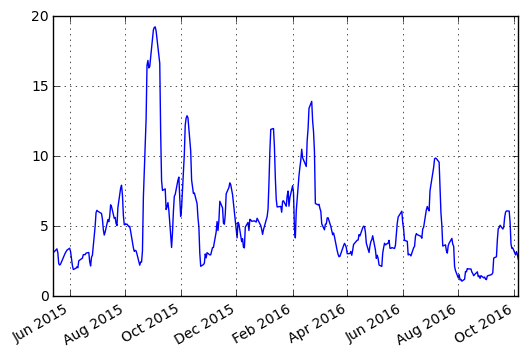

In [11]:
# Plot the 10D historical volatility over time
spx_hv10d = get_hv_10s(spx_5d_ma, window_len=10)
spx_hv10d.plot()

## Set up custom parsers for PyAlgoTrade

The following section sets up the custom parsers for the historical data that we just sourced for PyAlgoTrade; first is the RowParser that parses one single row of CSV file into a PyAlgoTrade Bar.

In [12]:
from pyalgotrade.barfeed import csvfeed
import datetime

class RowParser(csvfeed.RowParser):
    def __init__(self, dailyBarTime, frequency, timezone=None, sanitize=False):
        self.__dailyBarTime = dailyBarTime
        self.__frequency = frequency
        self.__timezone = timezone
        self.__sanitize = sanitize

    def __parseDate(self, dateString):

        def parse_date(date):
            try:
                return datetime.datetime.strptime(date, "%m/%d/%Y")
            except ValueError:
                return datetime.datetime.strptime(date, "%Y-%m-%d")
        
        ret = parse_date(dateString)
        # Time on Yahoo! Finance CSV files is empty. If told to set one, do it.
        if self.__dailyBarTime is not None:
            ret = datetime.datetime.combine(ret, self.__dailyBarTime)
        # Localize the datetime if a timezone was given.
        if self.__timezone:
            ret = dt.localize(ret, self.__timezone)
        return ret

    def getFieldNames(self):
        # It is expected for the first row to have the field names.
        return None

    def getDelimiter(self):
        return ","

    def parseBar(self, csvRowDict):
        dateTime = self.__parseDate(csvRowDict["Trade Date"])
        close = float(csvRowDict["Close"])
        open_ = float(csvRowDict["Open"])
        high = float(csvRowDict["High"])
        low = float(csvRowDict["Low"])
        if "Total Volume" in csvRowDict:
            volume = float(csvRowDict["Total Volume"])
        elif "Volume" in csvRowDict:
            volume = float(csvRowDict["Volume"])
        else:
            volume = 0
        adjClose = float(csvRowDict["Close"])

        if self.__sanitize:
            open_, high, low, close = common.sanitize_ohlc(open_, high, low, close)
        
        if high < low: #fix for bad bars where the open interest is 0, and you have weird conditions
            return None
        
        return bar.BasicBar(dateTime, open_, high, low, close, volume, adjClose, self.__frequency)

In [13]:
# Testing the RowParser with historical data csv file
from pyalgotrade.utils import csvutils
from pyalgotrade import bar
import datetime
import pprint

path = "vix_historical_data.csv"
rowParser =  RowParser(datetime.time(0, 0, 0), bar.Frequency.DAY, None, False)

loadedBars = []
reader = csvutils.FastDictReader(open(path, "r"), fieldnames=rowParser.getFieldNames(), delimiter=rowParser.getDelimiter())
for row in reader:
    bar_ = rowParser.parseBar(row)
    
    if bar_ is not None:
        loadedBars.append(bar_)


print "Length of Loaded Bars:"
print len(loadedBars)
print "First Bar:"
print loadedBars[0].__getstate__()

Length of Loaded Bars:
369
First Bar:
(datetime.datetime(2015, 4, 24, 0, 0), 12.21, 12.29, 13.02, 12.16, 0, 12.29, 86400, False)


## Create a PyAlgoFeed Feed and Strategy

In [14]:
from pyalgotrade.barfeed import common
from pyalgotrade.utils import dt
from pyalgotrade import bar
from pyalgotrade import dataseries

class Feed(csvfeed.BarFeed):
    """A :class:`pyalgotrade.barfeed.csvfeed.BarFeed` that loads bars from CSV files downloaded from Yahoo! Finance.

    :param frequency: The frequency of the bars. Only **pyalgotrade.bar.Frequency.DAY** or **pyalgotrade.bar.Frequency.WEEK**
        are supported.
    :param timezone: The default timezone to use to localize bars. Check :mod:`pyalgotrade.marketsession`.
    :type timezone: A pytz timezone.
    :param maxLen: The maximum number of values that the :class:`pyalgotrade.dataseries.bards.BarDataSeries` will hold.
        Once a bounded length is full, when new items are added, a corresponding number of items are discarded from the opposite end.
    :type maxLen: int.

    .. note::
        Yahoo! Finance csv files lack timezone information.
        When working with multiple instruments:

            * If all the instruments loaded are in the same timezone, then the timezone parameter may not be specified.
            * If any of the instruments loaded are in different timezones, then the timezone parameter must be set.
    """

    def __init__(self, frequency=bar.Frequency.DAY, timezone=None, maxLen=dataseries.DEFAULT_MAX_LEN):
        if isinstance(timezone, int):
            raise Exception("timezone as an int parameter is not supported anymore. Please use a pytz timezone instead.")

        if frequency not in [bar.Frequency.DAY, bar.Frequency.WEEK]:
            raise Exception("Invalid frequency.")

        csvfeed.BarFeed.__init__(self, frequency, maxLen)
        self.__timezone = timezone
        self.__sanitizeBars = False

    def sanitizeBars(self, sanitize):
        self.__sanitizeBars = sanitize

    def barsHaveAdjClose(self):
        return True
    
    def addBarsFromPd(self, instrument, timeseries, timezone=None):
        loadedBars = []
        
        for (timestamp, price) in timeseries.iteritems():
            dateTime = timestamp
            close = price
            open_ = price
            high = price
            low = price
            volume = 0
            adjClose = price
            
            currentBar = bar.BasicBar(dateTime, open_, high, low, close, volume, adjClose, self.getFrequency())
            loadedBars.append(currentBar)
  
        self.addBarsFromSequence(instrument, loadedBars)

    def addBarsFromCSV(self, instrument, path, timezone=None):
        """Loads bars for a given instrument from a CSV formatted file.
        The instrument gets registered in the bar feed.

        :param instrument: Instrument identifier.
        :type instrument: string.
        :param path: The path to the CSV file.
        :type path: string.
        :param timezone: The timezone to use to localize bars. Check :mod:`pyalgotrade.marketsession`.
        :type timezone: A pytz timezone.
        """

        if isinstance(timezone, int):
            raise Exception("timezone as an int parameter is not supported anymore. Please use a pytz timezone instead.")

        if timezone is None:
            timezone = self.__timezone

        rowParser = RowParser(self.getDailyBarTime(), self.getFrequency(), timezone, self.__sanitizeBars)
        csvfeed.BarFeed.addBarsFromCSV(self, instrument, path, rowParser)

## Set up the Tony Cooper's VRP Strategy

In [54]:
from pyalgotrade import strategy 

class MyStrategy(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, useAdjustedClose=True, threshold=7.8, threshold2=7.5, pct_allocation=0.25, max_allocation=0.32, cash=100000):
        strategy.BacktestingStrategy.__init__(self, feed, cash)
        self.setUseAdjustedValues(useAdjustedClose)
        self.__instrument = instrument
        self.threshold = threshold
        self.threshold2 = threshold2
        self.pct_allocation = pct_allocation
        self.max_allocation = max_allocation
               
    def onBars(self, bars):
        vrp_close = None
        vix_close = None
        
        def liquidate():
            positions = self.getBroker().getPositions()
            vxxShares = 0
            xivShares = 0
            
            if "VXX" in positions:
                vxxShares = positions["VXX"]
            if "XIV" in positions:
                xivShares = positions["XIV"]
            
            #self.info("liquidate")
            self.marketOrder("VXX", -vxxShares, goodTillCanceled=True)
            self.marketOrder("XIV", -xivShares, goodTillCanceled=True)
        
        def trade(vxxOn=True, shares=100):
            positions = self.getBroker().getPositions()
            vxxShares = 0
            xivShares = 0
        
            if "VXX" in positions:
                vxxShares = positions["VXX"]
            if "XIV" in positions:
                xivShares = positions["XIV"]
                
            vxxDollarAmt = vxxShares * float(bars["VXX"].getClose())
            xivDollarAmt = xivShares * float(bars["XIV"].getClose())
            portfolioAmt = self.getBroker().getEquity()
            
            vxxOrderShares = 0
            xivOrderShares = 0
        
            if vxxOn: #VXX on
                if xivShares > 0: #liquidate XIV
                    self.marketOrder("XIV", -xivShares, goodTillCanceled=True)
                if vxxShares < 1 and math.fabs(shares - vxxShares) > 0: #not in the trade yet
                    #self.info("Order for VXX:")
                    self.marketOrder("VXX", shares - vxxShares, goodTillCanceled=True)
                elif vxxShares > 1 and (vxxDollarAmt/portfolioAmt) > self.max_allocation: # in the trade and hit max allocation
                    #reduce the allocation by 5pct
                    reduceShares = (portfolioAmt * 0.05) / float(bars["VXX"].getClose())
                    self.info("Reduce VXX allocation by " + str(reduceShares))
                    self.marketOrder("VXX", -reduceShares, goodTillCanceled=True)
            else:
                if vxxShares > 0: #liquidate VXX
                    self.marketOrder("VXX", -vxxShares, goodTillCanceled=True)
                if xivShares < 1 and math.fabs(shares - xivShares) > 0: #not in the trade yet
                    #self.info("Order for XIV:")
                    self.marketOrder("XIV", shares - xivShares, goodTillCanceled=True)
                elif xivShares > 1:
                    if (xivDollarAmt/portfolioAmt) > self.max_allocation: # in the trade and hit max allocation
                        #reduce the allocation by 5pct
                        reduceShares = (portfolioAmt * 0.05) / float(bars["XIV"].getClose())
                        self.info("Reduce XIV allocation by " + str(reduceShares))
                        self.marketOrder("XIV", -reduceShares, goodTillCanceled=True)
                    
        if "VRP" in bars.keys():
            bar = bars["VRP"]
            vrp_close = float(bar.getClose())
            
        if "VIX" in bars.keys():
            bar = bars["VIX"]
            vix_close = float(bar.getClose())
        
        if "VXX" not in bars.keys() or "XIV" not in bars.keys():
            return 
        
        vxx_close = float(bars["VXX"].getClose())
        xiv_close = float(bars["XIV"].getClose())
        dollar_amt = self.getBroker().getEquity() * self.pct_allocation
        
        if vix_close !=None and vrp_close != None:
            if vix_close - vrp_close > self.threshold: #XIV on
                shares = int(dollar_amt / xiv_close)
                trade(vxxOn=False, shares=shares)
            else: 
                if vix_close - vrp_close < self.threshold2: #VXX on
                    shares = int(dollar_amt / vxx_close)
                    trade(vxxOn=True, shares=shares)

## Running the Strategy

First load the feeds. Then run the backtest with it.

In [57]:
# Load the VIX and VXX feed from the CSV file
feed = Feed()
feed.addBarsFromCSV("XIV", "xiv_historical_data.csv")
feed.addBarsFromCSV("VXX", "vxx_historical_data.csv")
feed.addBarsFromCSV("VIX", "vix_historical_data.csv")
feed.addBarsFromPd("VRP", spx_hv10d)

In [58]:
# Evaluate the strategy with the feed's bars.
from pyalgotrade.stratanalyzer import returns
from pyalgotrade import plotter
from pyalgotrade.utils import stats

myStrategy = MyStrategy(feed, "VIX", useAdjustedClose=True)

returnsAnalyzer = returns.Returns()
myStrategy.attachAnalyzer(returnsAnalyzer)

# Attach the plotter to the strategy.
plt = plotter.StrategyPlotter(myStrategy, plotAllInstruments=False, plotBuySell=False)

# Plot the simple returns on each bar.
myStrategy.run()

2016-04-18 00:00:00 strategy [INFO] Reduce XIV allocation by 181.63838727


In [59]:
print "Final portfolio value: $%.2f" % myStrategy.getResult()
print "Anual return: %.2f %%" % (returnsAnalyzer.getCumulativeReturns()[-1] * 100)
print "Average daily return: %.2f %%" % (stats.mean(returnsAnalyzer.getReturns()) * 100)

Final portfolio value: $108794.71
Anual return: 8.79 %
Average daily return: 0.02 %


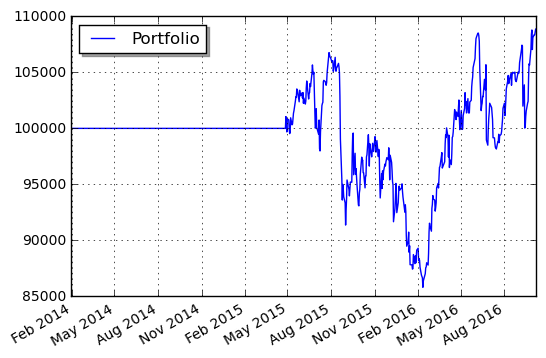

In [60]:
plt.plot()

## Running the VRP Strategy for a 3 year time period

In [23]:
# simple parameters
start_date = "01/09/2014"
end_date = "10/09/2016"

# Grabbing the VIX Historical Data
vix_filename2 = "vix_historical_data2.csv"
get_vix_historical_data(vix_filename2, "10/1/2013")
print "VIX historical data:"
read_lines(vix_filename2)

# Grabbing the VXX Historical Data
vxx_filename2 = "vxx_historical_data2.csv"
get_yahoo_historical_data(vxx_filename2, "VXX", start_date, end_date)
print "VXX Historical Data:"
read_lines(vxx_filename2)

# Grabbing the XIV Historical Data
xiv_filename2 = "xiv_historical_data2.csv"
get_yahoo_historical_data(xiv_filename2, "XIV", start_date, end_date)
print "XIV Historical Data:"
read_lines(xiv_filename2)

# Process the HV-10D of SPX 5D MA from SPX Historical Data
spx_pd = get_yahoo_historical_pandas("%5EGSPC", start_date, end_date)
spx_5d_ma = getTimeSeries(spx_pd, duration=5)
print "SPX HV-10D:"
spx_hv10d = get_hv_10s(spx_5d_ma, window_len=10)
print spx_hv10d[0:5]

VIX historical data:
['Trade Date,Open,High,Low,Close\r\n', '10/1/2013,16.31,16.46,15.47,15.54\r\n', '10/2/2013,16.4,16.81,16.13,16.6\r\n', '10/3/2013,16.63,18.71,16.63,17.67\r\n', '10/4/2013,17.72,17.87,16.66,16.74\r\n']
VXX Historical Data:
['Trade Date,Open,High,Low,Close,Volume,Adj Close\n', '2016-10-07,33.040001,33.970001,32.880001,33.279999,36767100,33.279999\n', '2016-10-06,33.599998,33.849998,33.07,33.200001,27544400,33.200001\n', '2016-10-05,33.369999,33.619999,33.200001,33.50,25106800,33.50\n', '2016-10-04,33.610001,34.619999,33.09,33.77,54864200,33.77\n']
XIV Historical Data:
['Trade Date,Open,High,Low,Close,Volume,Adj Close\n', '2016-10-07,38.689999,38.849998,37.59,38.389999,20434700,38.389999\n', '2016-10-06,38.02,38.639999,37.759998,38.50,12847400,38.50\n', '2016-10-05,38.349998,38.490002,38.009998,38.189999,14064200,38.189999\n', '2016-10-04,38.049999,38.630001,36.91,37.799999,33424100,37.799999\n']
SPX HV-10D:
2014-01-30    6.564439
2014-01-31    6.285892
2014-02-03    

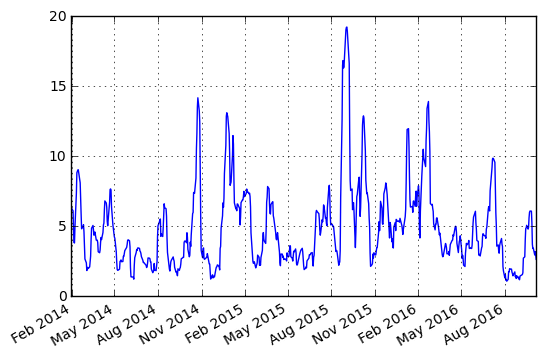

In [24]:
# Plot SPX HV-10D
spx_hv10d.plot()

In [40]:
# Load the VIX and VXX feed from the CSV file
feed2 = Feed()
feed2.addBarsFromCSV("XIV", "xiv_historical_data2.csv")
feed2.addBarsFromCSV("VXX", "vxx_historical_data2.csv")
feed2.addBarsFromCSV("VIX", "vix_historical_data2.csv")
feed2.addBarsFromPd("VRP", spx_hv10d)

# Evaluate the strategy with the feed's bars.
from pyalgotrade.stratanalyzer import returns
from pyalgotrade import plotter
from pyalgotrade.utils import stats

myStrategy = MyStrategy(feed2, "VIX", useAdjustedClose=True)

returnsAnalyzer = returns.Returns()
myStrategy.attachAnalyzer(returnsAnalyzer)

# Attach the plotter to the strategy.
plt = plotter.StrategyPlotter(myStrategy, plotAllInstruments=False, plotBuySell=False)

# Plot the simple returns on each bar.
myStrategy.run()

print "Final portfolio value: $%.2f" % myStrategy.getResult()
print "Anual return: %.2f %%" % (returnsAnalyzer.getCumulativeReturns()[-1] * 100)
print "Average daily return: %.2f %%" % (stats.mean(returnsAnalyzer.getReturns()) * 100)

2014-01-30 00:00:00 strategy [INFO] Order for XIV:
2014-02-11 00:00:00 strategy [INFO] Order for VXX:
2014-02-19 00:00:00 strategy [INFO] Order for XIV:
2014-04-21 00:00:00 strategy [INFO] Order for VXX:
2014-04-28 00:00:00 strategy [INFO] Order for XIV:
2014-05-30 00:00:00 strategy [INFO] Order for VXX:
2014-06-03 00:00:00 strategy [INFO] Order for XIV:
2014-06-18 00:00:00 strategy [INFO] Order for VXX:
2014-06-24 00:00:00 strategy [INFO] Order for XIV:
2014-08-13 00:00:00 strategy [INFO] Order for VXX:
2014-08-21 00:00:00 strategy [INFO] Order for XIV:
2014-10-21 00:00:00 strategy [INFO] Order for VXX:
2014-10-30 00:00:00 strategy [INFO] Order for XIV:
2014-12-22 00:00:00 strategy [INFO] Order for VXX:
2014-12-31 00:00:00 strategy [INFO] Order for XIV:
2015-03-18 00:00:00 strategy [INFO] Order for VXX:
2015-03-25 00:00:00 strategy [INFO] Order for XIV:
2015-06-22 00:00:00 strategy [INFO] Reduce XIV allocation by 122.658048646
2015-07-16 00:00:00 strategy [INFO] Order for VXX:
2015-07

Final portfolio value: $123347.03
Anual return: 23.35 %
Average daily return: 0.03 %


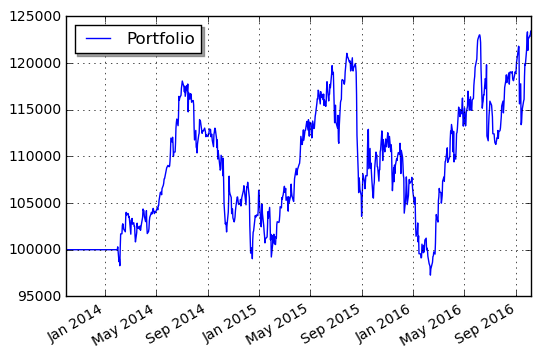

In [41]:
plt.plot()

## Optimizing Parameters

Optimize the various parameters by using PyAlgoTrade's Optimizer; the optimal parameters to find:

```
    threshold =[5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 7.8, 8.0, 8.5, 9.5, 10.0] 
    threshold2=[5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.5, 10.0]
    pct_allocation = 0.10 to 0.35 in increments of 0.01
```

In [56]:
import itertools
from pyalgotrade.optimizer import local

def parameters_generator():
    instrument = ["VIX"]
    useAdjustedClose = [True]
    threshold =[5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 7.8, 8.0, 8.5, 9.5, 10.0] 
    threshold2=[5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.5, 10.0]
    pct_allocation = [x * 0.01 for x in range(10, 35)]
    max_allocation = [0.80]
    cash = [100000]
    
    return itertools.product(instrument, useAdjustedClose, threshold, threshold2, pct_allocation, max_allocation, cash)

# Load the VIX and VXX feed from the CSV file
feed3 = Feed()
feed3.addBarsFromCSV("XIV", "xiv_historical_data2.csv")
feed3.addBarsFromCSV("VXX", "vxx_historical_data2.csv")
feed3.addBarsFromCSV("VIX", "vix_historical_data2.csv")
feed3.addBarsFromPd("VRP", spx_hv10d)

local.run(MyStrategy, feed3, parameters_generator())

2016-10-07 00:00:00 server [INFO] Loading bars
2016-10-07 00:00:00 server [INFO] Waiting for workers
2016-10-07 00:00:00 server [INFO] Partial result 117505.109827 with parameters: ('VIX', True, 6.0, 6.5, 0.34, 0.8, 100000) from worker-32124
2016-10-07 00:00:00 server [INFO] Partial result 104275.76197 with parameters: ('VIX', True, 5.0, 8.5, 0.34, 0.8, 100000) from worker-32122
2016-10-07 00:00:00 server [INFO] Partial result 108131.325693 with parameters: ('VIX', True, 5.5, 7.5, 0.34, 0.8, 100000) from worker-32121
2016-10-07 00:00:00 server [INFO] Partial result 118377.993387 with parameters: ('VIX', True, 7.0, 8.5, 0.34, 0.8, 100000) from worker-32131
2016-10-07 00:00:00 server [INFO] Partial result 117505.109827 with parameters: ('VIX', True, 6.0, 10.0, 0.34, 0.8, 100000) from worker-32123
2016-10-07 00:00:00 server [INFO] Partial result 115805.935086 with parameters: ('VIX', True, 6.5, 10.0, 0.34, 0.8, 100000) from worker-32126
2016-10-07 00:00:00 server [INFO] Partial result 123

## The best parameter was: 
```
threshold= 7.8
threshold = 7.5
allocation = 0.34
```